# Path embeddings with FastPATH - Examples

In this notebook we will show you several examples of constructing path embeddings with the FastPATH algorithm.
The full documentation for the algorithm can be found [here](https://docs.google.com/document/d/1oCAz6ukn_r19H27ghxnGM_-UQP9rgYJRhLzNLHdQc8Y/edit#heading=h.ya70gurwgyt2).

## The Dataset

We will use a synthetic medical dataset containing `Patients`, `Encounters`, `Conditions`, `Observations` and more.
Using FastPATH we will construct (path) embeddings for patient journey in the dataset.
The idea is to compare patient journey of patients who will get the diabetes diagnosis, and to those who will not.
This entails some visualization of the path embeddings, comparing pairwise distances, and try to train a classification algorithm for early diabetes detection.
There are around 1000 patients in the dataset, of which around 80 have received the diabetes diagnosis.

You need to replace the Neo4j URL and credentials to a database that contains the dataset.
Contact the GDS team if you're interested in that.

Below you can find the schema of the database:

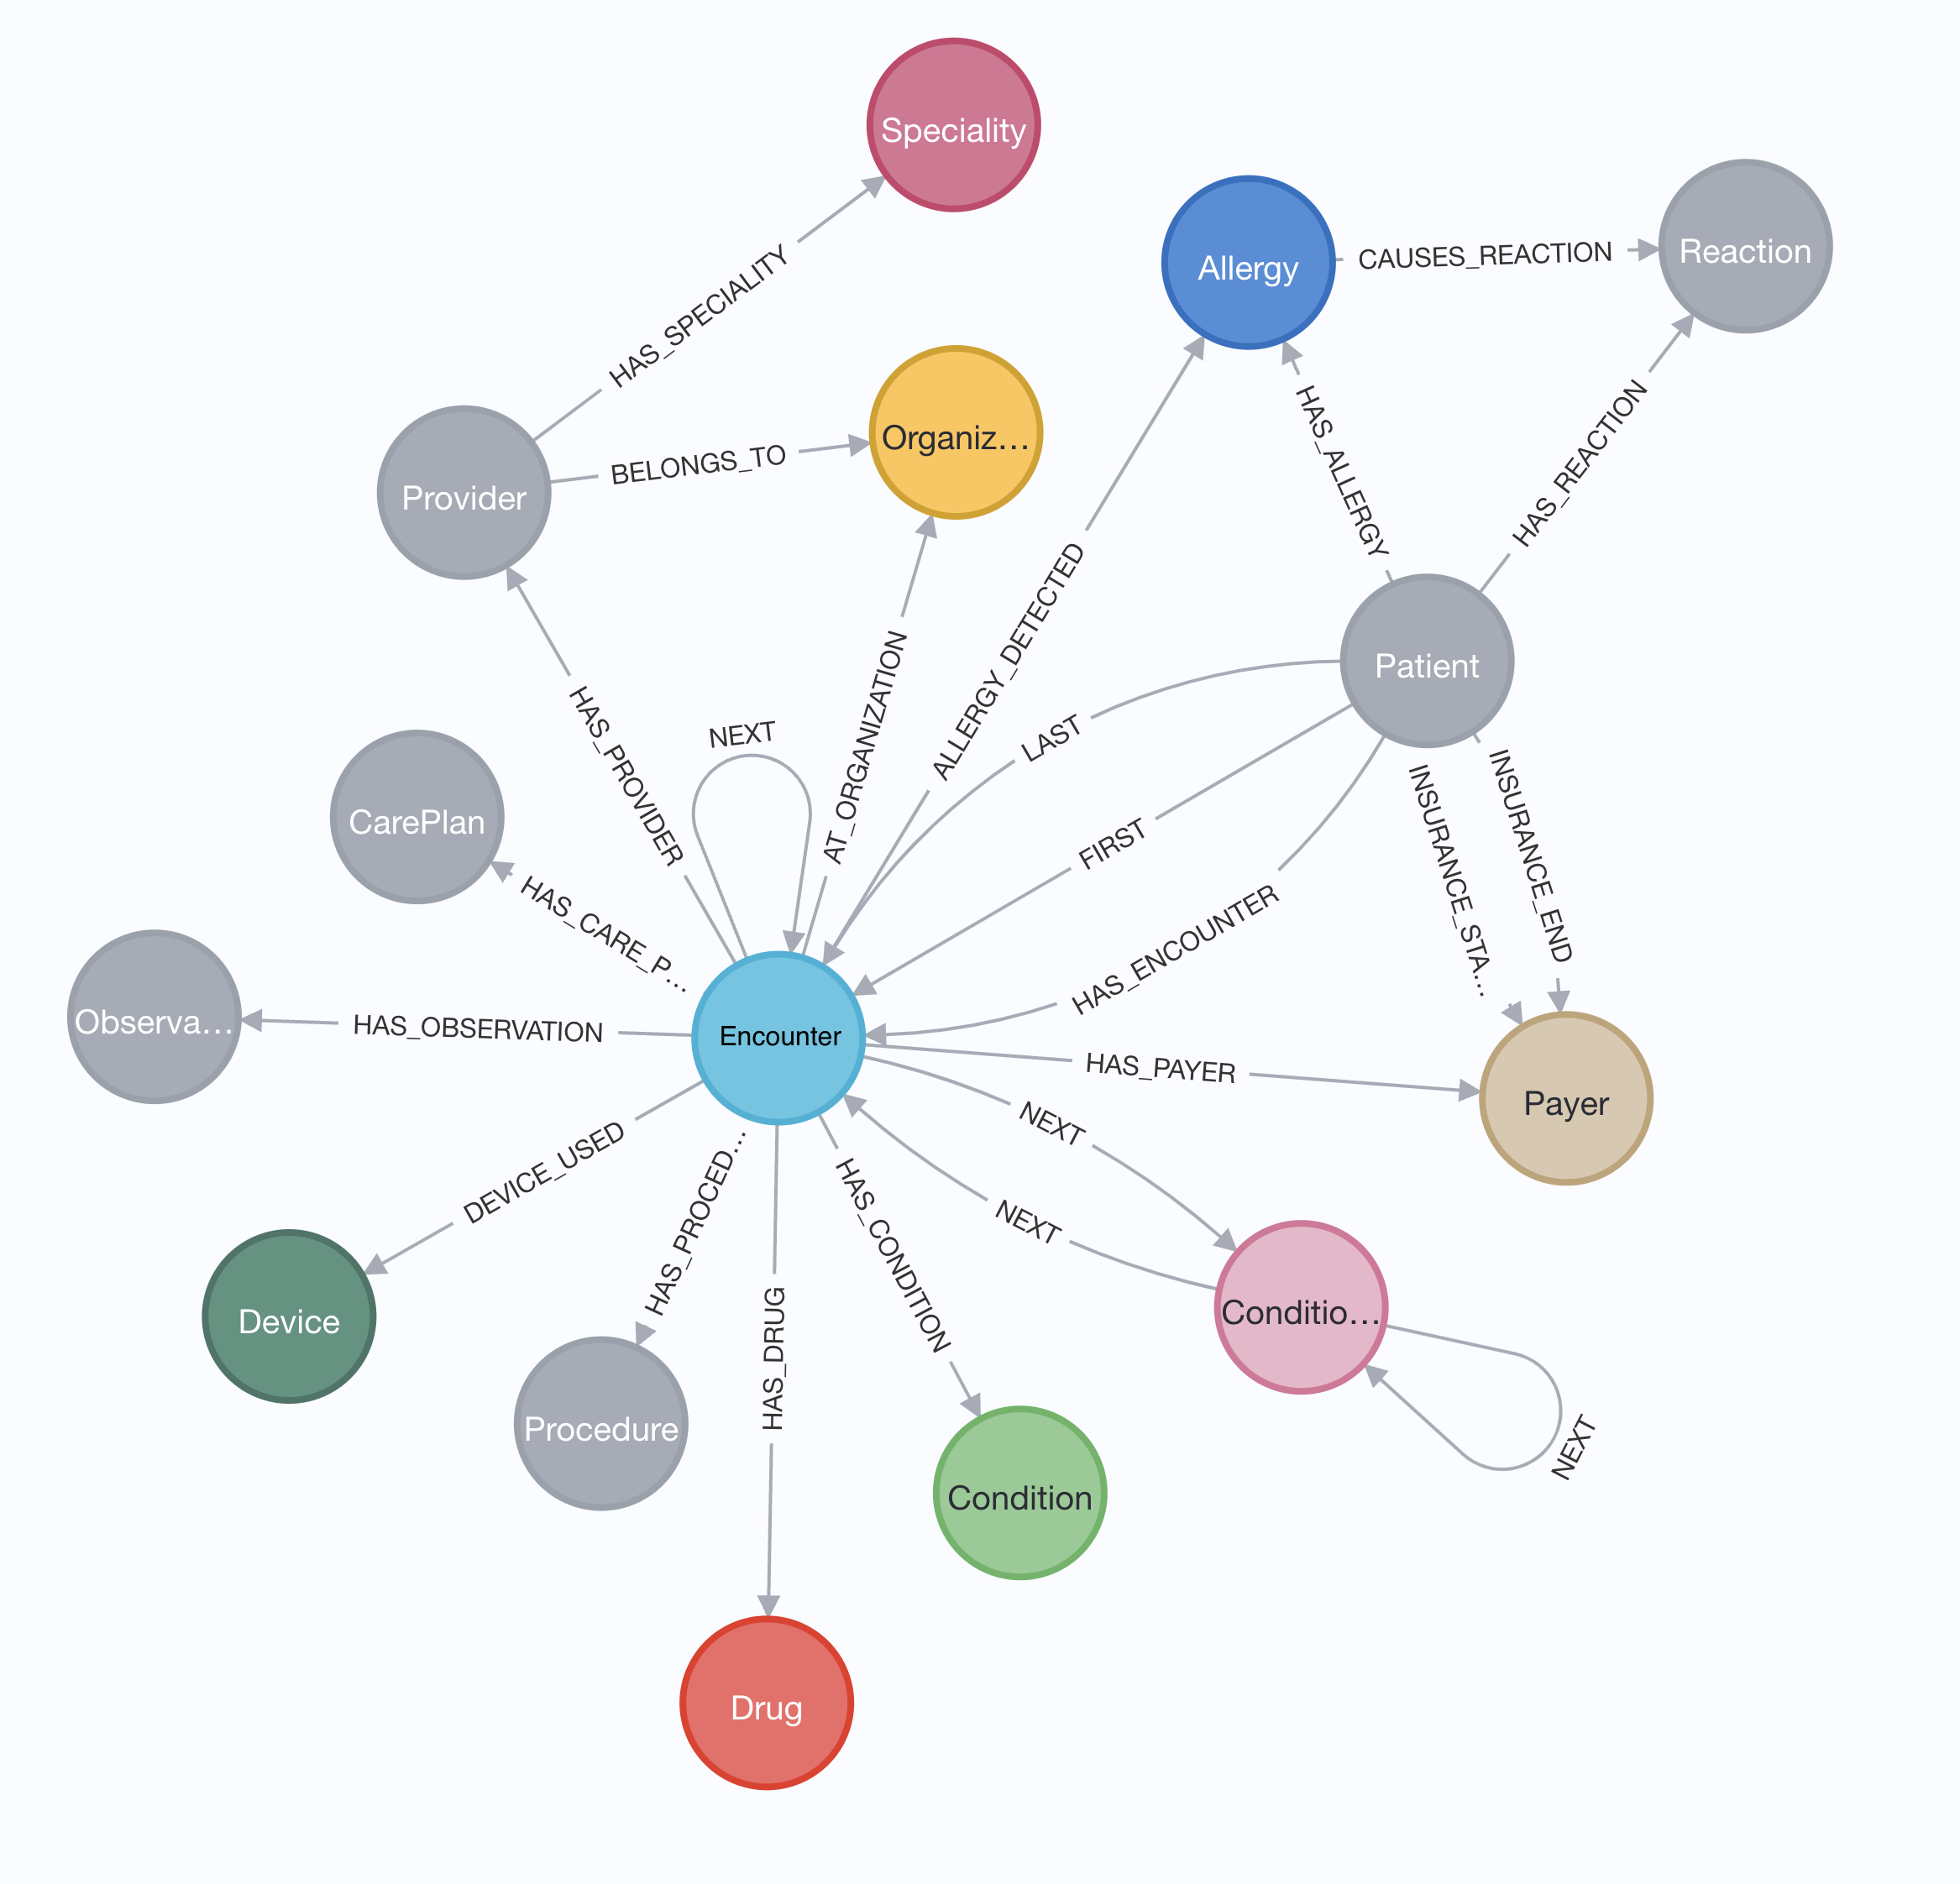

## Import and Setup

In [14]:
from graphdatascience import GraphDataScience
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [15, 10]

In [15]:
gds = GraphDataScience(
    "NEO4J_URI",
    auth=("neo4j", "PASSWORD"),
    database="neo4j",
)
# Temporary solution until we integrated with Aura/Snowflake
gds.set_compute_cluster_ip("localhost")

## Preprocessing

In order to make our dataset amenable to our analysis using FastPATH and downstream machine learning, we must augment it slightly.
This entails writing some additional node properties to the database with the Cypher code below.

**NOTE: Each preprocessing cell below must be run once, and only once.**

First we write a `has_diabetes` property (0 or 1) to each `Patient` node.
This will give us class labels that enable us to train a classification model on patient journeys later.

In [1]:
gds.run_cypher("MATCH (p:Patient) SET p.has_diabetes=0")
gds.run_cypher("MATCH (p:Patient)-[:HAS_ENCOUNTER]->(n:Encounter)-[:HAS_CONDITION]-(c:Condition) WHERE c.description='Diabetes' SET p.has_diabetes=1")

Then to each `Encounter` node, we write the number of days that has passed since 1 January 1970 (can be negative), based on the existing `start` node property.
We do this since the `start` property it already has is not an actual number, which is what the algorithm needs.
This is needed in the case where we don't rely on `NEXT` relationships for event timestamps, which is one of the examples below.

In [ ]:
gds.run_cypher("MATCH (n:Encounter) WITH toInteger(datetime(n.start).epochseconds/(24 * 3600)) as days, n SET n.days=days")

Next we write two output time properties to each `Patient` based on the last `Encounter` before a diabetes diagnosis, or the last `Encounter` otherwise.
* For the case where we are relying on the `days` node property on `Encounter`s (see above), the new `output_time` node property for `Patient`s will be equal to 1 + the `days` timestamp of their last encounter (before diabetes if they have it).
* For the case where we are relying on `FIRST` and `NEXT` relationships to define the `Encounter`s belonging to a `Patient`, the new `output_time_stepwise` node property for `Patient`s will be equal to the number of encounters up to and including the last encounter (before diabetes if they have it).

With these properties we can specify the point in time for which we want the path embeddings for each `Patient` node.
I.e. the paths that is embedded will continue up to that point, but not longer.

In [2]:
# Writing the `output_time` `Patient` node property
gds.run_cypher("MATCH (p:Patient)-[:LAST]->(n:Encounter) SET p.output_time=n.days+1")
gds.run_cypher("MATCH (p:Patient)-[:HAS_ENCOUNTER]->(e1:Encounter)-[:NEXT]->(e2:Encounter)-[:HAS_CONDITION]->(c:Condition) WHERE c.description='Diabetes' SET p.output_time=e1.days + 1")

# Writing `output_time_stepwise` `Patient` node property
gds.run_cypher("MATCH (p:Patient)-[:HAS_ENCOUNTER]->(e:Encounter) WHERE e.days <= p.output_time - 1 WITH p, count(*) as cc SET p.output_time_stepwise=cc")

Lastly we write the `class` of each `Encounter` as an integer property `intClass`.
Doing so enables us to use the class property as input to the algorithm, impacting the internal embeddings of `Encounter` nodes.

In [ ]:
gds.run_cypher(
    """
    MATCH (e:Encounter) with distinct e.class AS class
    WITH collect(class) as clss
    WITH apoc.map.fromLists(clss, range(0, size(clss) - 1)) as classMap
    MATCH (e:Encounter) SET e.intClass = classMap[e.class]
    """
)

## Projection

For the first examples, we rely on the `days` property of `Encounter` nodes for timestamp.
For this reason we don't need to project `FIRST` and `NEXT` relationships.

In [ ]:
try:
    G = gds.graph.get("medical")
    G.drop()
except:
    pass

G, _ = gds.graph.project(
    "medical",
    {
        "Patient": {"properties": ["output_time", "has_diabetes"]},
        "Encounter": {"properties": ["days", "intClass"]},
        "Observation": {"properties": []},
        "Payer": {"properties": []},
        "Provider": {"properties": []},
        "Organization": {"properties": []},
        "Speciality": {"properties": []},
        "Allergy": {"properties": []},
        "Reaction": {"properties": []},
        "Condition": {"properties": []},
        "Drug": {"properties": []},
        "Procedure": {"properties": []},
        "CarePlan": {"properties": []},
        "Device": {"properties": []},
        "ConditionDescription": {"properties": []},
    },
    [
        "HAS_OBSERVATION",
        "HAS_ENCOUNTER",
        "HAS_PROVIDER",
        "AT_ORGANIZATION",
        "HAS_PAYER",
        "HAS_SPECIALITY",
        "BELONGS_TO",
        "INSURANCE_START",
        "INSURANCE_END",
        "HAS_ALLERGY",
        "ALLERGY_DETECTED",
        "HAS_REACTION",
        "CAUSES_REACTION",
        "HAS_CONDITION",
        "HAS_DRUG",
        "HAS_PROCEDURE",
        "HAS_CARE_PLAN",
        "DEVICE_USED",
    ],
)

## FastRP Features

We should make use of the topological information we have around in `Encounter` node.
For example, what `Condition`s, `Drug`s, `Procedure`s, etc. (see schema above) are connected to it.
And perhaps one hop in the graph beyond that.
To do so, we make use of FastRP to create node embeddings.
Later we can input the node embeddings of the `Encounter` nodes to the FastPATH algorithm using the `event_features` parameter.

In [47]:
gds.fastRP.mutate(
    G,
    embeddingDimension=256,
    mutateProperty="emb",
    iterationWeights=[1, 1],
    randomSeed=42,
)

nodePropertiesWritten                                                82395
mutateMillis                                                             0
nodeCount                                                            82395
preProcessingMillis                                                      0
computeMillis                                                          233
configuration            {'randomSeed': 42, 'mutateProperty': 'emb', 'j...
Name: 0, dtype: object

## Preparation of machine learning and visualization of embeddings

Below we define a utility function that we can subsequently use to analyze the path embeddings we produce in each example below.
This function does three things:
1. Computes the average pairwise distances between embeddings of the different class combinations (no diabetes vs diabetes)
2. Plot the path embeddings in two dimensions with t-SNE
3. Train and evaluate a logistic regression diabetes classifier which takes path embeddings as input

**NOTE: You don't have to read or understand this function, but can think of it as a black box in the context of this notebook.**

In [34]:
@ignore_warnings(category=ConvergenceWarning)
def explore(embeddings):
     
    # Compute pairwise distances between embeddings of healty<->healthy, sick<->sick and healthy<->sick.
    
    diabetes_by_nodeId = gds.graph.streamNodeProperties(G, ['has_diabetes'], ['Patient']).set_index('nodeId')[['propertyValue']]
    emb_and_diabetes = embeddings[['nodeId', "embeddings"]].set_index('nodeId').merge(diabetes_by_nodeId, left_index=True, right_index=True)
    healthy_embs = np.array(emb_and_diabetes[emb_and_diabetes.propertyValue == 0]["embeddings"].tolist())
    diabetes_embs = np.array(emb_and_diabetes[emb_and_diabetes.propertyValue == 1]["embeddings"].tolist())
    
    diabetes_distances = []
    for i in range(diabetes_embs.shape[0]):
        for j in range(i + 1, diabetes_embs.shape[0]):
            x1 = diabetes_embs[i, :]
            x2 = diabetes_embs[j, :]
            diabetes_distances.append(np.linalg.norm(x1 - x2))

    print(f"Avg diabetes<->diabetes L2-distances: {np.mean(diabetes_distances)}")

    healthy_distances = []
    for i in range(healthy_embs.shape[0]):
        for j in range(i + 1, healthy_embs.shape[0]):
            x1 = healthy_embs[i, :]
            x2 = healthy_embs[j, :]
            healthy_distances.append(np.linalg.norm(x1 - x2))
    
    print(f"Avg healthy<->healthy L2-distances: {np.mean(healthy_distances)}")
    
    mixed_distances = []
    for i in range(diabetes_embs.shape[0]):
        for j in range(healthy_embs.shape[0]):
            x1 = diabetes_embs[i, :]
            x2 = healthy_embs[j, :]
            mixed_distances.append(np.linalg.norm(x1 - x2))
    
    print(f"Avg healthy<->diabetes L2-distances: {np.mean(mixed_distances)}")
    
    # TSNE time
    
    X = np.array(emb_and_diabetes["embeddings"].tolist())
    y = emb_and_diabetes.propertyValue.to_numpy()
    tsne = TSNE(2)
    tsne_result = tsne.fit_transform(X)
    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=10)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    
    # Train evaluate diabetes classifier :)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
        
    train_f1_score = f1_score(y_train, y_train_pred, average="macro")
    test_f1_score = f1_score(y_test, y_test_pred, average="macro")
        
    print("Diabetes classifier scores:")
    print(f"Train set f1: {train_f1_score}")
    print(f"Test set f1: {test_f1_score}")

## Examples with the `(:Base)->(:Event)` Schema

In the following few examples direct relationships between `Patient` nodes and `Encounter` nodes will tell us which encounters happened to which patients.
The `days` node property on `Encounter` nodes dictate when an encounter has occurred.

### Individual Output Times

Firstly, we'll consider the case where there's an individual timestamp for each `Patient` node at which we would like to have a path embedding.
For this we provide the the "output_time" node property that we created above in the Preparation section.

We'll start by only using the FastRP embeddings as input to `Encounter` nodes, later we will add more.

In [25]:
try:
    gds.graph.nodeProperties.drop(G, ["embeddings"])
except:
    pass

gds.fastpath.mutate(
    G,
    base_node_label="Patient",
    event_node_label="Encounter",
    event_features="emb",
    time_node_property="days",
    dimension=256,
    num_elapsed_times=100,
    output_time_property="output_time",
    max_elapsed_time=365 * 10, # 10 years
    smoothing_rate=0.004,
    smoothing_window=3,
    decay_factor=1e-4,
    random_seed=42,
)

INFO:root:Job with ID 'e526613c-158f-45c2-be29-d66f3b66204c' started
INFO:root:FastPath job completed!


      nodeId                                         embeddings
0          0  [-3.604538766779251, -8.240581664441889, -7.91...
1          1  [7.668953402062965, -8.22828048714957, -13.014...
2          2  [-4.41605332646514, -13.241961089969516, 4.629...
3          3  [4.872529346865112, -12.216631937947739, -17.0...
4          4  [-5.228330521458478, -12.04373786505886, -9.36...
...      ...                                                ...
1128    1130  [3.709327252039838, 0.22428553060025308, 3.954...
1129    1131  [-0.611421132116078, -18.90183366733843, -25.9...
1130    1132  [373.48060345131717, -345.7270889385589, -540....
1131    1133  [16.55134670763396, 3.133196167916513, -13.250...
1132    1134  [1.9949496425686286, -2.5817058138797826, -0.3...

[1133 rows x 2 columns]
Avg diabetes<->diabetes L2-distances: 114.90496194068363
Avg healthy<->healthy L2-distances: 377.0693297989956
Avg healthy<->diabetes L2-distances: 269.9149326098692
Diabetes classifier scores:
Train set f1:

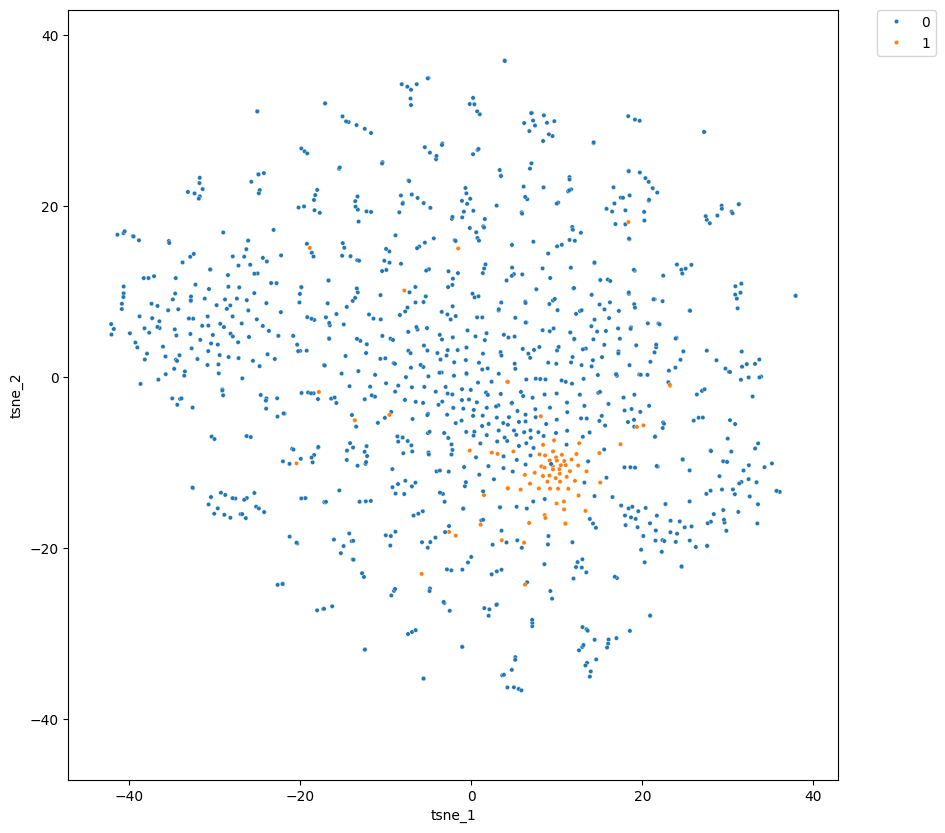

In [27]:
embeddings = gds.graph.nodeProperties.stream(G, ["embeddings"], node_labels=["Patient"], separate_property_columns=True)
print(embeddings)
explore(embeddings)

We get a very decent test set F1 score of ~0.84, despite the small and imbalanced dataset (~1000 patients of which ~80 have diabetes).
And we can see in the t-SNE plot that the algorithm is able to cluster the diabetes patient well even though FastPath is unsupervised.

Interestingly the healthy<->healthy distances are larger than the healthy<->diabetes on average, which may seem counterintuitive.
But this is simply due to the fact that the diabetes patient are located centrally in the embedding spaces, which can be seen in the plot above. 

### Adding the Categorical `Encounter` Property

As the type (class) of encounter may be important to characterize patient journeys and to classify diabetes, we add the `intClass` node property as a categorical event property to the input.

In [48]:
try:
    gds.graph.nodeProperties.drop(G, ["embeddings"])
except:
    pass

gds.fastpath.mutate(
    G,
    base_node_label="Patient",
    event_node_label="Encounter",
    event_features="emb",
    time_node_property="days",
    categorical_event_properties=['intClass'],
    dimension=256,
    num_elapsed_times=100,
    output_time_property="output_time",
    max_elapsed_time=365 * 10, # 10 years
    smoothing_rate=0.004,
    smoothing_window=3,
    decay_factor=1e-4,
    random_seed=42,
)

INFO:root:Job with ID '5fed577b-4c60-4961-bf79-26948d3f1a8d' started
INFO:root:FastPath job completed!


      nodeId                                         embeddings
0          0  [-3.389403302076928, -9.29506966802477, -9.180...
1          1  [7.1371660829140575, -6.556708840198025, -14.0...
2          2  [-3.365649144930392, -15.15229758712129, 5.265...
3          3  [6.989654287394879, -13.250023922129083, -14.7...
4          4  [4.924822941109173, -13.285868959933568, 7.996...
...      ...                                                ...
1128    1130  [4.39154542304379, 0.11948889453564793, 2.6826...
1129    1131  [20.195998004276664, -20.917418761165987, -19....
1130    1132  [597.3302250908247, -336.2961397659088, -340.1...
1131    1133  [63.67188727376424, 1.6527639289300036, -38.05...
1132    1134  [0.8964331449223741, -3.810741173428462, 1.389...

[1133 rows x 2 columns]
Avg diabetes<->diabetes L2-distances: 127.33969808726104
Avg healthy<->healthy L2-distances: 422.3028383808963
Avg healthy<->diabetes L2-distances: 301.7529098551756
Diabetes classifier scores:
Train set f1:

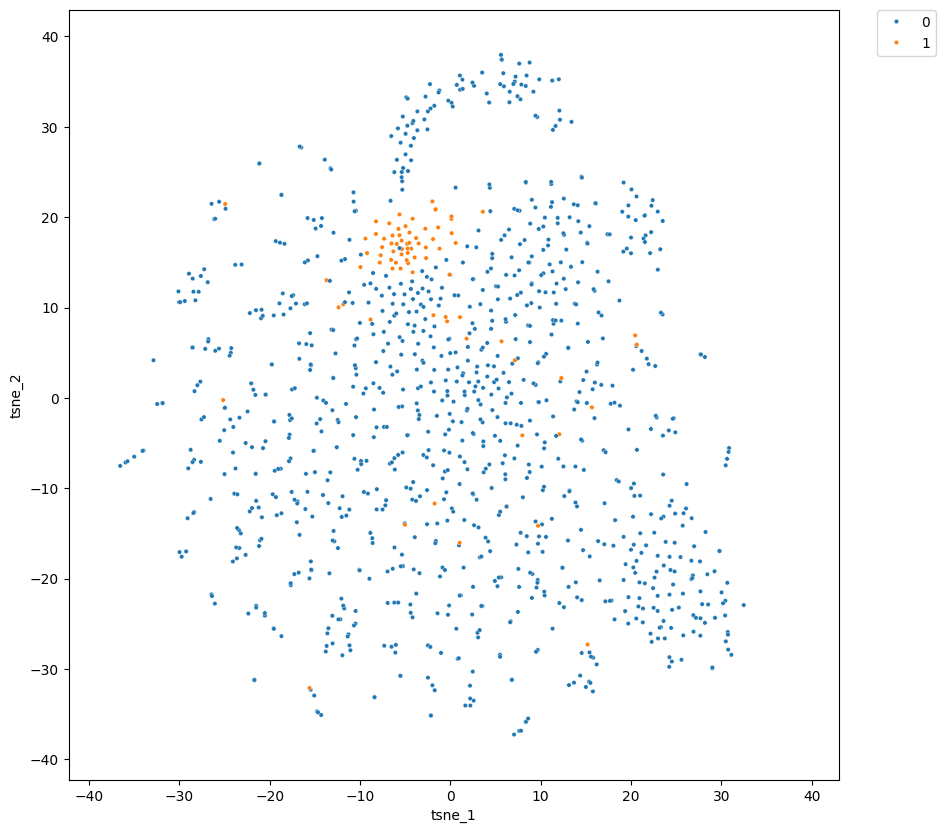

In [49]:
embeddings = gds.graph.nodeProperties.stream(G, ["embeddings"], node_labels=["Patient"], separate_property_columns=True)
print(embeddings)
explore(embeddings)

We note that the diabetes test set F1 score gets even better! Indeed, there are probably more node properties of the dataset that could be useful if one wishes to explore this further.
Note however that we have not used any node properties on the `Drug` nodes.
We have just used the topology of how `Drug` nodes are connected to `Encounter` nodes.

### Adding `Drug` Context Nodes

As the history of drugs may be important to characterize patient journeys and to classify diabetes, we add `Drug` nodes as `context_node_label`.

Note that we are still using the FastRP embeddings for `Encounter` nodes as input features to the events (encounters), but no longer the categorical property.

In [38]:
try:
    gds.graph.nodeProperties.drop(G, ["embeddings"])
except:
    pass

gds.fastpath.mutate(
    G,
    base_node_label="Patient",
    context_node_label="Drug",
    event_node_label="Encounter",
    event_features="emb",
    time_node_property="days",
    dimension=256,
    num_elapsed_times=100,
    output_time_property="output_time",
    max_elapsed_time=365 * 10, # 10 years
    smoothing_rate=0.004,
    smoothing_window=3,
    decay_factor=1e-4,
    random_seed=43,
)


INFO:root:Job with ID '1428eea2-3e8a-44ee-a776-f7b50b6a6ae6' started
INFO:root:FastPath job completed!


      nodeId                                         embeddings
0          0  [2.247203370725185, 3.8344897314513293, 2.9129...
1          1  [9.224103906697556, 1.6898980156248418, 7.4909...
2          2  [20.681224137765682, 10.559681875092885, 2.186...
3          3  [2.867877600492201, 10.314669783268744, -5.499...
4          4  [-15.370589369811496, 3.6023016493591946, 17.5...
...      ...                                                ...
1128    1130  [3.661598104571011, 3.947342290361916, -3.7805...
1129    1131  [20.109867046625187, 16.45373232501359, -13.19...
1130    1132  [204.76214351325225, 606.6379248137561, -776.7...
1131    1133  [-80.88413675464838, -83.47347756137651, 27.68...
1132    1134  [2.3573985390622516, -0.9356737731872571, 0.39...

[1133 rows x 2 columns]
Avg diabetes<->diabetes L2-distances: 126.8737133187533
Avg healthy<->healthy L2-distances: 450.51950807461157
Avg healthy<->diabetes L2-distances: 312.559124797766
Diabetes classifier scores:
Train set f1: 

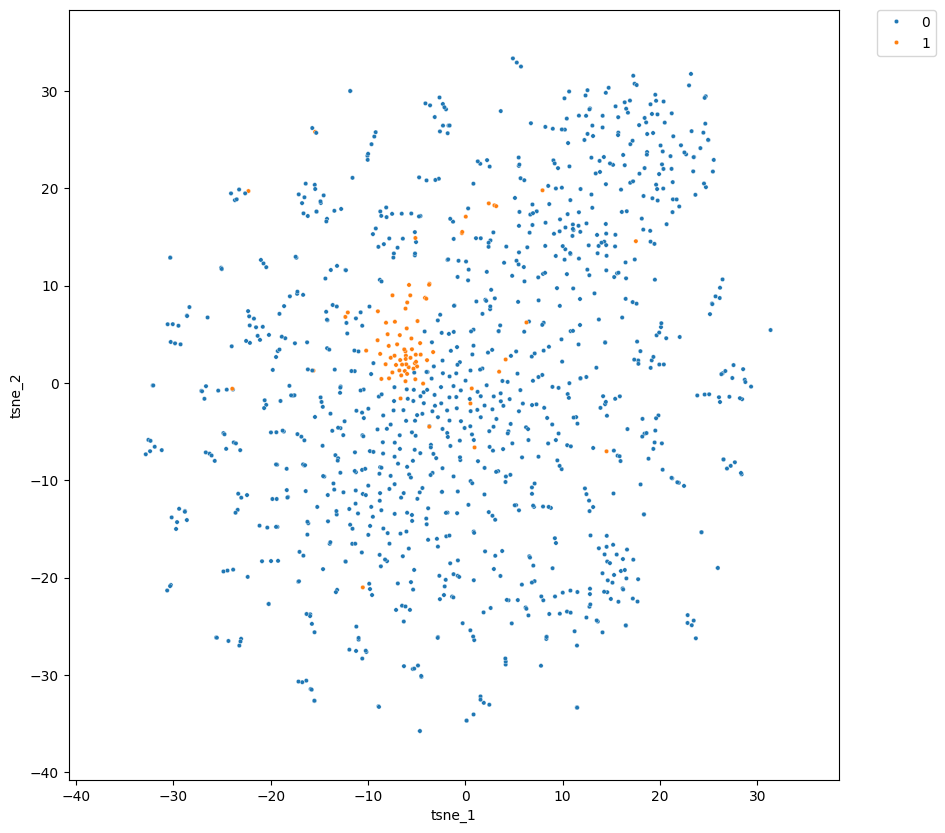

In [39]:
embeddings = gds.graph.nodeProperties.stream(G, ["embeddings"], node_labels=["Patient"], separate_property_columns=True)
print(embeddings)
explore(embeddings)

This is the best test set F1 score so far, so it seems like what kind of drugs are prescribed to patients is very useful to detect diabetes.

### Global Output Time

Next we will configure the algorithm to output path embeddings for the same timestamp for all `Patient` nodes.

To use a single fixed output time, you can either:
* Use the algorithm parameter `output_time` (and optionally use subgraph filtering to run only up to a certain time), or
* Use Cypher to write a output time property to the `Patient` nodes holding a fixed timestamp, and then provide it as `output_time_property`

Here we will use the first option.

Note that we are still using the FastRP embeddings for `Encounter` nodes as input features to the events (encounters), but no longer the categorical property.

In [40]:
try:
    gds.graph.nodeProperties.drop(G, ["embeddings"])
except:
    pass

gds.fastpath.mutate(
    G,
    base_node_label="Patient",
    event_node_label="Encounter",
    event_features="emb",
    time_node_property="days",
    dimension=256,
    num_elapsed_times=100,
    output_time=365 * 50, # 50 years
    max_elapsed_time=365 * 10, # 10 years
    smoothing_rate=0.004,
    smoothing_window=3,
    decay_factor=1e-5,
    random_seed=42,
)

INFO:root:Job with ID '0c75ad23-4dbe-4e31-8ca9-b91042ad5e0e' started
INFO:root:FastPath job completed!


status    ok
dtype: object

      nodeId                                         embeddings
0          0  [-3.013269538438305, -6.020968938455281, -4.24...
1          1  [7.7043894304949685, -4.495488839208988, -16.7...
2          2  [7.415187256951267, -18.021083980227395, -4.67...
3          3  [7.28810773284838, -7.475891414691468, -8.1665...
4          4  [-2.2118758556291884, -21.871706397461413, -1....
...      ...                                                ...
1128    1130  [2.633515932585782, 2.229432104979241, -0.2265...
1129    1131  [16.131910876101596, -11.626443365851973, 0.32...
1130    1132  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1131    1133  [6.793301721278904, -10.961005238891458, -15.7...
1132    1134  [-34.07920126934665, 13.929082818395543, -116....

[1133 rows x 2 columns]
Avg diabetes<->diabetes L2-distances: 592.1659624308521
Avg healthy<->healthy L2-distances: 298.3267522051091
Avg healthy<->diabetes L2-distances: 457.1177091937383
Diabetes classifier scores:
Train set f1: 

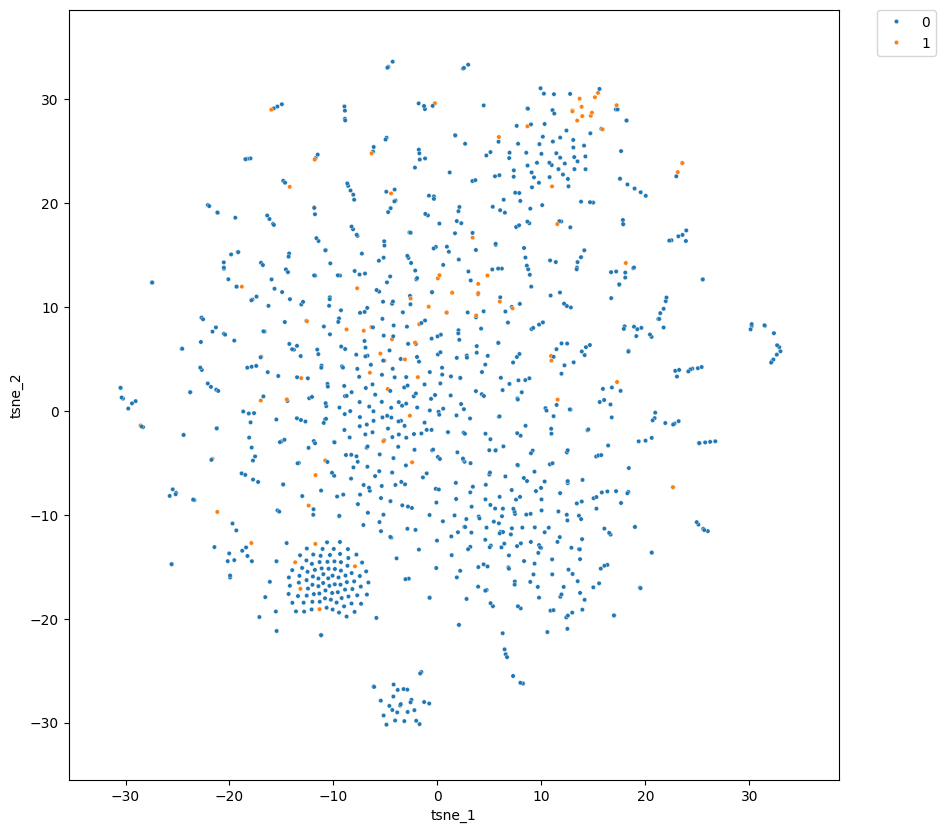

In [41]:
embeddings = gds.graph.nodeProperties.stream(G, ["embeddings"], node_labels=["Patient"], separate_property_columns=True)
print(embeddings)
explore(embeddings)

We get a significantly worse score in this case.
But honestly, this method does not really work for this dataset.
For example, most diabetes have probably received their diagnosis as part of the path that is embedded.
Other patients may not have had treatment for the last ten years, and so they will receive 0-vectors.

We include this example anyway to show that it is possible to use a "global" timestamp.

## Reprojecting for the `FIRST` and `NEXT` Relationships Schema

Now we will consider an alternative path schema which the FastPath algorithm also supports.
In this case a `Patient` node is connected via a `FIRST` relationship to the first (in order) `Encounter` node in its series of associated encounters.
All subsequent encounters of this `Patient` are connected to the first `Encounter` through a chain of `NEXT` relationships:

`(:Patient)-[:FIRST]->(:Encounter)-[:NEXT]->...-[:NEXT]->(:Encounter)`

The order of the encounters in the chain also dictates the order that the encounters occur.

The first step is to create a new projection that includes the `FIRST` and `NEXT` relationships, and the `output_time_stepwise` properly we will use later.

In [ ]:
try:
    G = gds.graph.get("medical")
    G.drop()
except:
    pass

G, _ = gds.graph.project(
    "medical",
    {
        "Patient": {"properties": ["output_time", "output_time_stepwise", "has_diabetes"]},
        "Encounter": {"properties": ["days", "intClass"]},
        "Observation": {"properties": []},
        "Payer": {"properties": []},
        "Provider": {"properties": []},
        "Organization": {"properties": []},
        "Speciality": {"properties": []},
        "Allergy": {"properties": []},
        "Reaction": {"properties": []},
        "Condition": {"properties": []},
        "Drug": {"properties": []},
        "Procedure": {"properties": []},
        "CarePlan": {"properties": []},
        "Device": {"properties": []},
        "ConditionDescription": {"properties": []},
    },
    [
        "HAS_OBSERVATION",
        "NEXT",
        "FIRST",
        "HAS_PROVIDER",
        "AT_ORGANIZATION",
        "HAS_PAYER",
        "HAS_SPECIALITY",
        "BELONGS_TO",
        "INSURANCE_START",
        "INSURANCE_END",
        "HAS_ALLERGY",
        "ALLERGY_DETECTED",
        "HAS_REACTION",
        "CAUSES_REACTION",
        "HAS_CONDITION",
        "HAS_DRUG",
        "HAS_PROCEDURE",
        "HAS_CARE_PLAN",
        "DEVICE_USED",
    ],
)

## New FastRP Features

Now that we have a new projection we of course have to recompute the FastRP node embeddings.
Note that we this time explicitly list which relationships we allow the algorithm to use.
In particular, we exclude the `NEXT` relationships since it would imply that an `Encounter` node's embedding would be impacted by future encounters.
This would of course be cheating.

In [62]:
gds.fastRP.mutate(
    G,
    embeddingDimension=256,
    mutateProperty="emb",
    iterationWeights=[1, 1],
    randomSeed=42,
    relationshipTypes=[
        "HAS_OBSERVATION",
        "HAS_PROVIDER",
        "AT_ORGANIZATION",
        "HAS_PAYER",
        "HAS_SPECIALITY",
        "BELONGS_TO",
        "INSURANCE_START",
        "INSURANCE_END",
        "HAS_ALLERGY",
        "ALLERGY_DETECTED",
        "HAS_REACTION",
        "CAUSES_REACTION",
        "HAS_CONDITION",
        "HAS_DRUG",
        "HAS_PROCEDURE",
        "HAS_CARE_PLAN",
        "DEVICE_USED",
    ]
)

nodePropertiesWritten                                                82395
mutateMillis                                                             0
nodeCount                                                            82395
preProcessingMillis                                                      0
computeMillis                                                          202
configuration            {'randomSeed': 42, 'mutateProperty': 'emb', 'j...
Name: 0, dtype: object

## Examples with the `FIRST` and `NEXT` Relationships Schema

### Still Using `time_node_property`

We will now repeat one of the previous examples, but with the new schema.
Note that though the order of encounters is implied by the `NEXT` relationships, in this example we use the `time_node_property` anyway which of course also implicitly tell us the order of encounters.

In [73]:
try:
    gds.graph.nodeProperties.drop(G, ["embeddings"])
except:
    pass

gds.fastpath.mutate(
    G,
    base_node_label="Patient",
    event_node_label="Encounter",
    event_features="emb",
    context_node_label="Drug",
    next_relationship_type="NEXT",
    first_relationship_type="FIRST",
    time_node_property="days",
    dimension=256,
    num_elapsed_times=100,
    output_time_property="output_time",
    max_elapsed_time=365 * 10, # 10 years
    smoothing_rate=0.004,
    smoothing_window=3,
    decay_factor=1e-5,
    random_seed=43,
)

INFO:root:Job with ID 'b8e44388-88ba-4ac6-b502-c15d31d5875a' started
INFO:root:FastPath job completed!


status    ok
dtype: object

      nodeId                                         embeddings
0          0  [2.268406749836677, 3.769139799152188, 3.07608...
1          1  [12.281622940762794, 1.5488010340178564, 9.482...
2          2  [22.589258302362747, 12.179788828751168, 3.861...
3          3  [4.179891073673431, 11.149127038930246, -5.382...
4          4  [-19.001413200330543, 2.782762509906463, 21.89...
...      ...                                                ...
1128    1130  [3.909982929162243, 4.153150363297369, -3.8550...
1129    1131  [24.516025726408795, 19.50513950872726, -15.97...
1130    1132  [215.0991069459835, 670.6819275528654, -849.56...
1131    1133  [-88.57190760897817, -94.04790606443844, 32.99...
1132    1134  [2.414213196331178, -0.975778958181024, 0.6828...

[1133 rows x 2 columns]
Avg diabetes<->diabetes L2-distances: 142.72892632933682
Avg healthy<->healthy L2-distances: 510.7560940686594
Avg healthy<->diabetes L2-distances: 354.3316372171365
Diabetes classifier scores:
Train set f1:

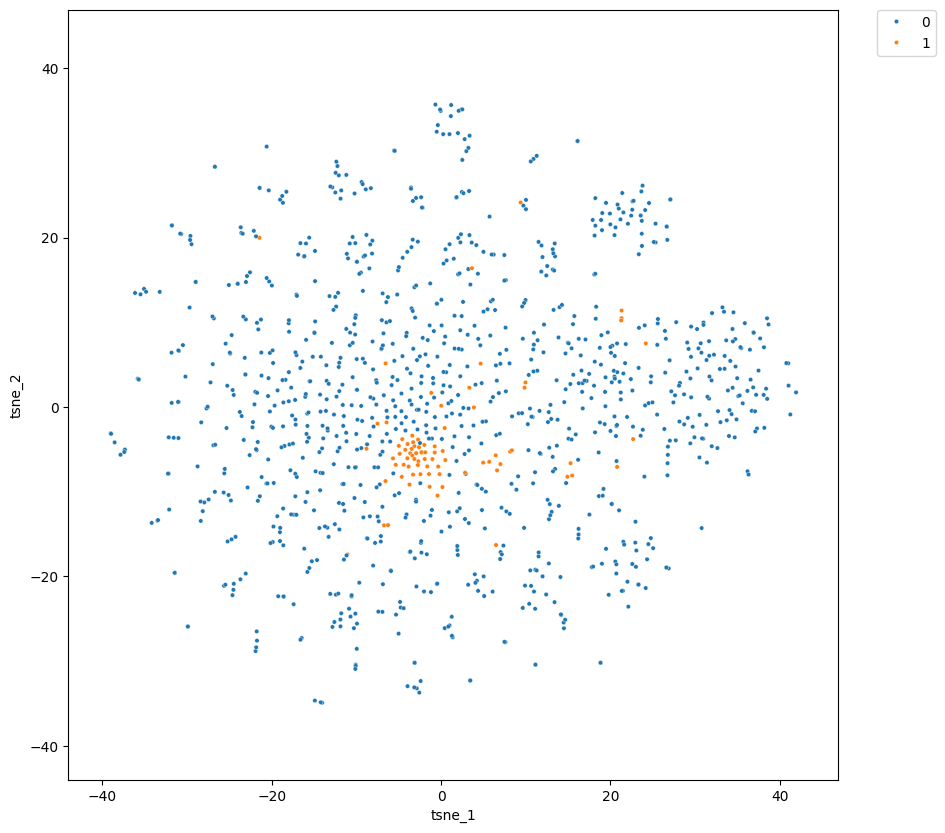

In [74]:
embeddings = gds.graph.nodeProperties.stream(G, ["embeddings"], node_labels=["Patient"], separate_property_columns=True)
print(embeddings)
explore(embeddings)

As we can see, the score is very similar to when we had the same configuration but a different input schema.
The slight variation is due to numerical precision noise and rounding when computing the embeddings.

### Depending on `NEXT` for Time

In this example we remove the `time_node_property` from our FastPath configuration.
This means that the timestamp of each `Encounter` node will be derived from its position the `NEXT`-chain it is part of.

Note also that we now use the `output_time_stepwise` node property which properly matches the time scale of the `NEXT`-chains.

In [75]:
try:
    gds.graph.nodeProperties.drop(G, ["embeddings"])
except:
    pass

gds.fastpath.mutate(
    G,
    base_node_label="Patient",
    event_node_label="Encounter",
    event_features="emb",
    context_node_label="Drug",
    next_relationship_type="NEXT",
    first_relationship_type="FIRST",
    dimension=256,
    num_elapsed_times=100,
    output_time_property="output_time_stepwise",
    max_elapsed_time=365 * 10, # 10 years
    smoothing_rate=0.004,
    smoothing_window=3,
    decay_factor=1e-5,
    random_seed=43,
)

INFO:root:Job with ID '7c8b0343-2951-45ae-a0da-397e83bd848b' started
INFO:root:FastPath job completed!


status    ok
dtype: object

      nodeId                                         embeddings
0          0  [4.464728516826299, 10.983947555604765, 4.1848...
1          1  [-5.386957874727056, 12.159342708734084, -9.66...
2          2  [35.581563847693424, 6.146688811251319, -8.965...
3          3  [-11.789936242252724, 18.316365810517137, -14....
4          4  [6.389088599095343, 41.31359296198347, -14.096...
...      ...                                                ...
1128    1130  [-5.4945942209402165, 5.505186442399516, -3.77...
1129    1131  [-70.18565680799323, 43.544509702038795, 19.92...
1130    1132  [-112.73053537567975, -255.15152483202363, -16...
1131    1133  [-64.14543631514452, -60.84491873989887, 12.75...
1132    1134  [0.7705607931135692, 4.3847868993512416, -7.15...

[1133 rows x 2 columns]
Avg diabetes<->diabetes L2-distances: 328.4398642045539
Avg healthy<->healthy L2-distances: 650.2257344535276
Avg healthy<->diabetes L2-distances: 512.5030330045197
Diabetes classifier scores:
Train set f1: 

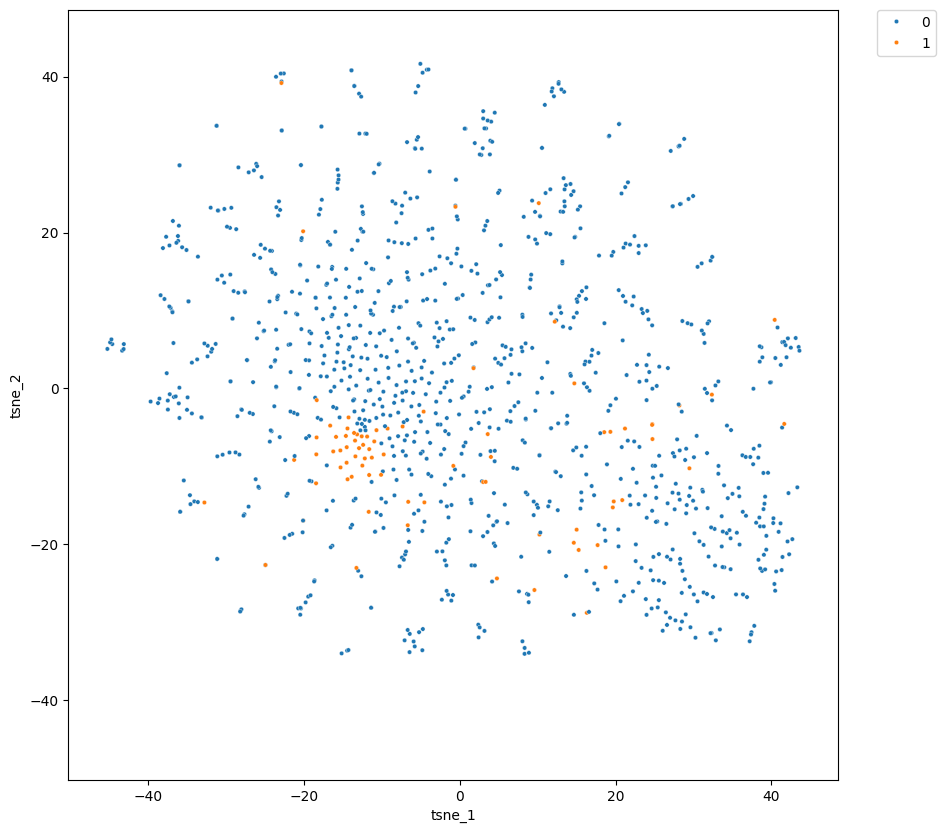

In [76]:
embeddings = gds.graph.nodeProperties.stream(G, ["embeddings"], node_labels=["Patient"], separate_property_columns=True)
print(embeddings)
explore(embeddings)

As we can see the score we get is worse than when we also include the exact timestamps.
Even so, the there seems to be a lot of signal in just the order of the encounters of each patient.